# Air Quality Measurements in New Zealand - Interpolation

* Author: Fabian Löw
* Date: June 2023

We will explore various techniques for filling in gaps in air quality data sets in this notebook. The workflow includes the following steps:

1. Import necessary Python packages and functions from the "utils.py" file.
2. Load the data from a CSV file, which represents the last step in the "01_Air_Quality_EDA" notebook.
3. Create visualizations to analyze the extent and distribution of missing data.
4. Assess the nearest neighbor method for interpolation.
5. Preprocess the data to prepare it for training a neural network model.
6. Train and test a neural network model to estimate missing data.
7. Compare the results of the neural network model with a baseline model through visualizations.
8. Estimate missing sensor measurements for all pollutants.
9. Visualize the results of filling in the missing values.
10. Save the resulting dataset to a new CSV file.

*Some parts of the code have been taken from a DeepLearning.AI training repository (AI for Good)*

## 1. Import Python packages

In [5]:
# Import basic modules
import pandas as pd
from datetime import datetime
import utils

# If needed, reload the utils.py (e.g. if any adjustments are made)
import importlib 
utils = importlib.reload(utils)

# scikit-learn modules
from sklearn.model_selection import train_test_split

print('All packages imported successfully!')

All packages imported successfully!


In [6]:
# Install packages form pip, only use if requirements not already satisfied
# !pip install tensorflow

## 2. Load the data

Run the next cell to load the air quality data from New Zealand that was processed in the notebook "01_Air_Quality_EDA".

In [7]:
# Read in the data from the previous notebook
collapsed_df = pd.read_csv('collapsed_df.csv')
collapsed_df['DateTime'] = pd.to_datetime(collapsed_df['DateTime'])

# Define a list all of the pollutants that you will be working with
pollutants_list = ['PM2.5', 'PM10'] #,  'NO2', 'SO2', 'CO']

print(f"The dataset contains {len(collapsed_df)} entries")
print(f"The measurements are from {collapsed_df.Station.nunique()} different locations in New Zealand")

# Print out the first few lines in the dataframe
collapsed_df.head(5)

The dataset contains 105863 entries
The measurements are from 24 different locations in New Zealand


,DateTime,Station,lat,long,PM2.5,PM10
0,2005-01-01,Ashburton,-43.912238,171.755200,NaN,9.0
1,2005-01-01,Geraldine,-44.100181,171.241500,NaN,2.0
2,2005-01-01,Kaiapoi,-43.384643,172.652000,NaN,9.0
3,2005-01-01,Masterton West,-40.952307,175.646614,NaN,10.0
4,2005-01-01,Penrose,-36.904610,174.815600,NaN,12.0


## 3. Visualize the extent and distribution of missing data

### 3.1 Count null values

In [8]:
# Print out a count of missing data for each column in the dataset
collapsed_df.isnull().sum()

DateTime        0
Station         0
lat             0
long            0
PM2.5       49896
PM10          775
dtype: int64

### 3.2. Plot measurements over time for different pollutants at different stations

To generate a time series plot depicting the variation of a chosen pollutant over time at a specific sensor station, execute the cell below. Utilize the drop-down menus to select different stations and pollutants, correspondingly. Employ the sliders to zoom in or out on a specific date range. The values for start_date and end_date are automatically calculated.

In [9]:
# Plot a time series graph for a specific range of dates, pollutant, and sensor station
common_start_date = min(collapsed_df.DateTime)
common_end_date = max(collapsed_df.DateTime)

start_date = common_start_date
end_date = common_end_date
utils.create_time_series_plot(collapsed_df, start_date, end_date, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Geraldine', 'Kaiapoi', 'Masterton…

### 3.3 Visualize the distribution of gaps in the data

To generate a plot illustrating the relationship between the count of gap sizes in hours (horizontal axis) and the number of missing data points resulting from those gaps (vertical axis), run the code cell below. This plot will offer valuable insights into how gaps of different sizes impact the occurrence of missing data.

5445


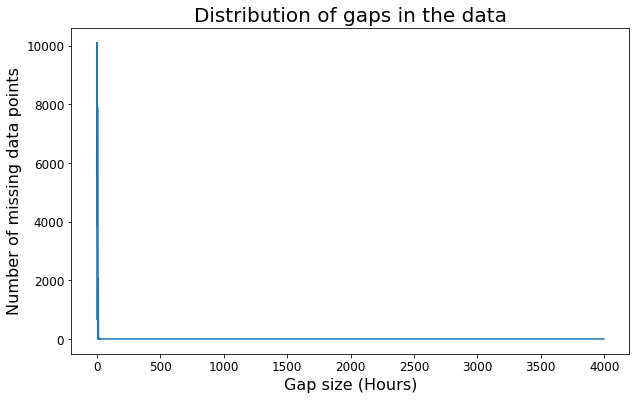

In [7]:
# Plot the distribution of gap sizes in the data
utils.plot_distribution_of_gaps(collapsed_df, target='PM2.5') # or 'PM10'

## 4. Evaluate nearest neighbor method

In the following cell, evaluate the nearest neighbor method and compute the Mean Absolute Error (MAE). This metric quantifies the average disparity between the actual and predicted values. It is important to recognize that the nearest neighbor method has certain limitations. For instance, if there is only one measurement station in the city, filling gaps with the "nearest" station in another city may lead to inaccuracies. It is advisable to consider the density of the measurement network and explore more advanced techniques like inverse distance weighting.

In [10]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = utils.calculate_mae_for_nearest_station(collapsed_df, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 4.630670965416773}


## 5. Prepare the data to train a neural network model

Next, we will prepare the dataset to train and test a neural network model for estimating missing pullutant values (e.g. PM2.5 or PM10).

### 5.1. Remove missing values and add columns for later use with a neural network model
To achieve this, you will start by removing all rows from the original dataset that have missing values. Then, you will introduce gaps of different sizes into the data to assess how your model performs. Before discarding rows with missing values, you will enhance the dataset by adding extra columns that are crucial for training a neural network model. These additional columns will include the day of the week (`day_week`). Additionally, in the line of code where the variable `one_hot` is defined, the station ID will be converted into a numerical representation, indicating the particular station linked to each measurement.

In [12]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week
raw_data_for_imputing = collapsed_df.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
# raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  

# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)

# Print out the number of missing values in the selected column (e.g. PM1.5 or PM10) 
# as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


In [13]:
# Visualize the firts few rows of the dataframe
data_no_missing.head()

,DateTime,Station,lat,long,PM2.5,PM10,day_week,Station_Ashburton,Station_Blenheim Bowling Club,Station_Claudelands,...,Station_St Albans,Station_St Johns,Station_Takapuna,Station_Timaru Anzac Square,Station_Waimate Kennedy,Station_Wainuiomata,Station_Waitomo District Council Yard - Queen St,Station_Wellington Central,"Station_Whangarei, Robert Street",Station_Woolston
5445,2006-08-10,Penrose,-36.90461,174.8156,10.0,18.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5459,2006-08-11,Penrose,-36.90461,174.8156,9.0,18.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5473,2006-08-12,Penrose,-36.90461,174.8156,5.0,13.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5487,2006-08-13,Penrose,-36.90461,174.8156,5.0,14.0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5501,2006-08-14,Penrose,-36.90461,174.8156,8.0,19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2 Split data into training and testing sets

To ensure a consistent evaluation between your baseline model and the neural network model, it is essential to perform the test on the same subset of the data. In this step, you will divide the data and generate a distinct testing dataset. This testing dataset will be employed to assess both your baseline model and the neural network model. Execute the following cell to allocate 20% of the data specifically for testing purposes.

In [14]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (44153, 31)
Test dataset size: (11039, 31)




    
</details>



## 6. Train and test a neural network model for estimating missing data

Execute the following code cell to train and test a neural network model for estimating missing PM2.5 values. In this scenario, the neural network needs to learn the relationship between PM2.5 values and other pollutant values, as well as factors such as time of day, day of the week, and station location. It's important to note that the actual neural network used in training is larger than the one depicted in the image, consisting of two hidden layers with 64 and 32 units, respectively.

In [15]:
# Define the features you will base your predictions on 
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week'] + list(one_hot.columns) + pollutants_except_target

# Define the neural network model architecture
model_dense = utils.build_keras_model(input_size=len(feature_names))
model_lstm = utils.build_lstm_model(input_size=len(feature_names))

# Train and test the models (simple dense and LSTM)
model_dense, scaler, mae_dense = utils.train_and_test_model(feature_names, target, train_data, test_data, model_dense)
model_lstm, scaler, mae_lstm = utils.train_and_test_model(feature_names, target, train_data, test_data, model_lstm)

2023-07-11 19:39:47.430137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
690/690 [==============================] - 1s 1ms/step - loss: 12.5129 - mae: 2.2844
Epoch 2/100
690/690 [==============================] - 1s 1ms/step - loss: 10.2567 - mae: 2.1207
Epoch 3/100
690/690 [==============================] - 1s 989us/step - loss: 9.9209 - mae: 2.0977
Epoch 4/100
690/690 [==============================] - 1s 1ms/step - loss: 9.7980 - mae: 2.0831
Epoch 5/100
690/690 [==============================] - 1s 1ms/step - loss: 9.7147 - mae: 2.0724
Epoch 6/100
690/690 [==============================] - 1s 980us/step - loss: 9.5483 - mae: 2.0655
Epoch 7/100
690/690 [==============================] - 1s 1ms/step - loss: 9.4921 - mae: 2.0557
Epoch 8/100
690/690 [==============================] - 1s 1ms/step - loss: 9.4850 - mae: 2.0548
Epoch 9/100
690/690 [==============================] - 1s 986us/step - loss: 9.4096 - mae: 2.0538
Epoch 10/100
690/690 [==============================] - 1s 979us/step - loss: 9.3831 - mae: 2.0501
Epoch 11/100
690/690 [=======

690/690 [==============================] - 1s 2ms/step - loss: 8.9109 - mae: 2.0083
Epoch 69/100
690/690 [==============================] - 1s 2ms/step - loss: 8.9470 - mae: 2.0083
Epoch 70/100
690/690 [==============================] - 1s 2ms/step - loss: 8.9701 - mae: 2.0086
Epoch 71/100
690/690 [==============================] - 1s 2ms/step - loss: 8.9227 - mae: 2.0096
Epoch 72/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9333 - mae: 2.0103
Epoch 73/100
690/690 [==============================] - 1s 2ms/step - loss: 8.9220 - mae: 2.0079
Epoch 74/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9417 - mae: 2.0090
Epoch 75/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8873 - mae: 2.0078
Epoch 76/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9334 - mae: 2.0044
Epoch 77/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9495 - mae: 2.0096
Epoch 78/100
690/690 [=====================

Compare the **MAE** obtained using the 2 methods (nearest neighbor and two neural network architectures). This value has been obtained using the same test set so its comparable.

In [16]:
# Print out the MAE result of the methods tested
regression_scores['neural_network_model_dense'] = mae_dense
regression_scores['neural_network_model_lstm'] = mae_lstm

for model_name, model_score in regression_scores.items():
    score_value = model_score['MAE']
    print(model_name, ' : {:.3f}'.format(float(score_value)))

baseline_model  : 4.631
neural_network_model_dense  : 1.991
neural_network_model_lstm  : 2.023


## 7. Visualize the results from the baseline model compared to the neural networks

Execute the subsequent cell to visualize the outcomes of both the baseline model and the neural network model. Utilize the drop-down menus to select various station locations and different "window" or gap sizes measured in hours. Adjust the slider to choose the starting index of the window you wish to examine. Additionally, you have the flexibility to modify the start_date and end_date values to different dates within the year 2021.

In [14]:
# Define start and end prrtiod for the plot
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 6, 6)

# Create a line plot showing results from  baseline model vs. neural networks
utils.create_plot_with_preditions(data_no_missing, 
                                  model_dense, 
                                  scaler, 
                                  feature_names, 
                                  target,
                                  start_date,
                                  end_date)

interactive(children=(Dropdown(description='Station', options=('Penrose', 'Takapuna', 'Patumahoe', 'St Albans'…

## 8. Estimate missing sensor measurements across all pollutants

The initial line of code provided below allows you to employ the nearest neighbors method for estimating missing values in all pollutants except PM2.5. Subsequently, using the second line, you can utilize your neural network model to estimate missing values specifically for PM2.5. Lastly, the last line of code simply displays the number of missing values in each column once more, and if the process was successful, the count should be zero.

In [17]:
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = utils.impute_nontarget_missing_values_interpolate(raw_data_for_imputing, 
                                                                                feature_names,
                                                                                pollutants_list,
                                                                                target)

# Estimate missing PM2.5 values 
data_with_imputed = utils.impute_target_missing_values_neural_network(raw_data_for_imputing, 
                                                                      model_dense, 
                                                                      scaler, 
                                                                      imputed_with_baseline_model,
                                                                      pollutants_list,
                                                                      target)

# Print the count of missing values in each column
data_with_imputed[pollutants_list].isnull().sum()

PM2.5    0
PM10     0
dtype: int64

In [18]:
# Print out a sample of the dataframe
data_with_imputed.sample(5)

,DateTime,Station,lat,long,PM2.5,PM10,PM2.5_imputed_flag,PM10_imputed_flag
76360,2017-07-27,Rotorua at Edmund Rd,-38.135818,176.214203,39.000000,45.00000,None,None
85182,2018-08-05,SWDC Billah St Water Reservoir,-38.221617,175.858430,7.242260,4.91245,None,None
25516,2010-05-20,Kaiapoi,-43.384643,172.652000,24.985809,32.00000,neural network,None
76231,2017-07-22,Blenheim Bowling Club,-41.526640,173.956082,28.000000,30.00000,None,None
18285,2009-02-03,St Albans,-43.511257,172.633700,6.505769,14.00000,neural network,None


The flag columns exhibit distinct values: `None` indicates the presence of original data, `'neural network'` signifies imputed values using the neural network, and `'interpolated'` represents values obtained through interpolation.

## 9. Visualize the results of filling in missing values

You can use the flag columns you recorded above to distinguish between original and estimated data, and you can visualize this by running the cell below.

In [19]:
# Define a start and end date and visualize missing values that have been imputed
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 4, 30)
utils.create_time_series_plot(data_with_imputed, start_date, end_date, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Geraldine', 'Kaiapoi', 'Masterton…

## 10. Write the resulting dataset to a new csv file

In [20]:
# Write imputed data as new csv file
data_with_imputed.to_csv('results/full_data_with_imputed_values.csv')

*[End of notebook]*